In [13]:
import numpy as np 
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold, GroupKFold

from sklearn.ensemble import VotingRegressor

#import optuna

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
import gc
pd.set_option('display.max_columns', None)
#########################################################
input_dir = 'data/'

In [14]:
# train.breath_id.unique()[(train.groupby('breath_id')['pressure'].max()<=0).values]


In [19]:
train = pd.read_csv(input_dir+'train.csv')
train['id'] = train['id']%80
train.loc[train.id==0] = 80
# train

In [20]:
# sns.distplot(id173.time_step.diff()[1:])
# test.groupby('breath_id')['u_in'].diff()
def features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_diff'] = (df['u_in']).groupby(df['breath_id']).diff().fillna(0)
    df['time_step_diff'] = (df['time_step']).groupby(df['breath_id']).diff().fillna(0)
    df['air_press_lung'] = df['time_step_diff']*df['u_in_diff']
    df['air_press_lung_cumsum'] = (df['air_press_lung']).groupby(df['breath_id']).cumsum()
    df['sgn_u_in_diff'] = np.sign(df['u_in_diff'])
    df['sgn_u_in_diff_cumsum'] = (df['sgn_u_in_diff']).groupby(df['breath_id']).cumsum()
    df['u_in_lag2'] = (df['u_in']).groupby(df['breath_id']).shift(2).fillna(0)
    df['u_in_lag4'] = (df['u_in']).groupby(df['breath_id']).shift(4).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df = pd.get_dummies(df)
    
    df['ewm_u_in_mean'] = df.groupby('breath_id')['u_in'].ewm(halflife=10).mean().reset_index(level=0,drop=True)
    df['ewm_u_in_std'] = df.groupby('breath_id')['u_in'].ewm(halflife=10).std().reset_index(level=0,drop=True)
    df['ewm_u_in_corr'] = df.groupby('breath_id')['u_in'].ewm(halflife=10).corr().reset_index(level=0,drop=True)
    
    df['rolling_10_mean'] = df.groupby('breath_id')['u_in'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
    df['rolling_10_max'] = df.groupby('breath_id')['u_in'].rolling(window=10, min_periods=1).max().reset_index(level=0,drop=True)
    df['rolling_10_std'] = df.groupby('breath_id')['u_in'].rolling(window=10, min_periods=1).std().reset_index(level=0,drop=True)
    
    df['expand_mean'] = df.groupby('breath_id')['u_in'].expanding(2).mean().reset_index(level=0,drop=True)
    df['expand_max'] = df.groupby('breath_id')['u_in'].expanding(2).max().reset_index(level=0,drop=True)
    df['expand_std'] = df.groupby('breath_id')['u_in'].expanding(2).std().reset_index(level=0,drop=True)
    
    return df

train_df = features(train)
train_df['time_step_log'] =np.log1p(train_df['time_step'])

# test = features(test)

In [21]:
# # train.size
# def dcast(df):
#     fcols = df.select_dtypes('float').columns
#     icols = df.select_dtypes('integer').columns

#     df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
#     df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
#     return df
# train= dcast(train)
# # test = dcast(test)


In [22]:
# cor['pressure']
# maxes = train_df.loc[train_df.u_out == 0].groupby('breath_id').agg('max').reset_index()
# maxes

In [23]:
# idx_mins = train_df.loc[train_df.u_out == 0].groupby('breath_id').agg('idxmin').reset_index()
# train['time_step_log'] =np.log1p(train['time_step'])

In [24]:
def new_fea(df):
    idx_mins0 = df.loc[df.u_out == 0].groupby('breath_id').agg('idxmin').reset_index()
    idx_mins1 = df.loc[df.u_out == 1].groupby('breath_id').agg('idxmin').reset_index()
    idx_maxs0 = df.loc[df.u_out == 0].groupby('breath_id').agg('idxmax').reset_index()
    idx_maxs1 = df.loc[df.u_out == 1].groupby('breath_id').agg('idxmax').reset_index()
    df_u_in_min0_u_in =  df.iloc[idx_mins0.u_in.values]
    df_u_in_min0_area =  df.iloc[idx_mins0.area.values]
    df_u_in_min0_u_in_diff =  df.iloc[idx_mins0.u_in_diff.values]
    df_u_in_min0_air_press_lung =  df.iloc[idx_mins0.air_press_lung_cumsum.values]
    df_u_in_min0_sgn_u_in_diff_cumsum =  df.iloc[idx_mins0.sgn_u_in_diff_cumsum.values]
    df_u_in_max0_u_in =  df.iloc[idx_maxs0.u_in.values]
    df_u_in_max0_area =  df.iloc[idx_maxs0.area.values]
    df_u_in_max0_u_in_diff =  df.iloc[idx_maxs0.u_in_diff.values]
    df_u_in_max0_air_press_lung =  df.iloc[idx_maxs0.air_press_lung_cumsum.values]
    df_u_in_max0_sgn_u_in_diff_cumsum =  df.iloc[idx_maxs0.sgn_u_in_diff_cumsum.values]
    df_u_in_min1_u_in =  df.iloc[idx_mins1.u_in.values]
    df_u_in_min1_area =  df.iloc[idx_mins1.area.values]
    df_u_in_min1_u_in_diff =  df.iloc[idx_mins1.u_in_diff.values]
    df_u_in_min1_air_press_lung =  df.iloc[idx_mins1.air_press_lung_cumsum.values]
    df_u_in_min1_sgn_u_in_diff_cumsum =  df.iloc[idx_mins1.sgn_u_in_diff_cumsum.values]
    df_u_in_max1_u_in =  df.iloc[idx_maxs1.u_in.values]
    df_u_in_max1_area =  df.iloc[idx_maxs1.area.values]
    df_u_in_max1_u_in_diff =  df.iloc[idx_maxs1.u_in_diff.values]
    df_u_in_max1_air_press_lung =  df.iloc[idx_maxs1.air_press_lung_cumsum.values]
    df_u_in_max1_sgn_u_in_diff_cumsum =  df.iloc[idx_maxs1.sgn_u_in_diff_cumsum.values]
    df_u_in_min0 = df_u_in_min0_u_in.merge(df_u_in_min0_area,on= 'breath_id').merge(df_u_in_min0_u_in_diff,on = 'breath_id').merge(df_u_in_min0_air_press_lung,on = 'breath_id').merge( df_u_in_min0_sgn_u_in_diff_cumsum,on = 'breath_id')
    df_u_in_max0 = df_u_in_max0_u_in.merge(df_u_in_max0_area,on= 'breath_id').merge(df_u_in_max0_u_in_diff,on = 'breath_id').merge(df_u_in_max0_air_press_lung,on = 'breath_id').merge( df_u_in_max0_sgn_u_in_diff_cumsum,on = 'breath_id')
    df_u_in_min1 = df_u_in_min1_u_in.merge(df_u_in_min1_area,on= 'breath_id').merge(df_u_in_min1_u_in_diff,on = 'breath_id').merge(df_u_in_min1_air_press_lung,on = 'breath_id').merge( df_u_in_min1_sgn_u_in_diff_cumsum,on = 'breath_id')
    df_u_in_max1 = df_u_in_max1_u_in.merge(df_u_in_max1_area,on= 'breath_id').merge(df_u_in_max1_u_in_diff,on = 'breath_id').merge(df_u_in_max1_air_press_lung,on = 'breath_id').merge( df_u_in_max1_sgn_u_in_diff_cumsum,on = 'breath_id')
    return df_u_in_min0.merge(df_u_in_max0,on = 'breath_id').merge(df_u_in_max1,on = 'breath_id').merge(df_u_in_min1,on = 'breath_id')
    
#       df_u_in_min0 =  df.iloc[idx_mins0.u_in.values]
#     df_u_in_min0 =  df.iloc[idx_mins0.u_in.values]
#     df_u_in_min0 =  df.iloc[idx_mins0.u_in.values]
#     df_u_in_min0 =  df.iloc[idx_mins0.u_in.values]

In [25]:
df = new_fea(train_df)


In [26]:
# corr_df = df.corr()


In [27]:
# corr_df.columns.tolist()

In [28]:
# abs(corr_df.loc['pressure_y'].iloc[0]).sort_values(ascending = False)
df_u = df.copy()

In [29]:
df.dropna(axis = 1,inplace = True)

In [30]:
df.drop(['pressure_y','pressure_x','pressure_y_y','pressure_y_x','pressure_x_y','pressure_x_x'],axis = 1,inplace = True)
# df['pressure_y']

In [38]:
# df['pressure']
# df.columns
# df
# ids = ['id_y','id_x','id_y_y','id_y_x','id_x_y','id_x_x']
# for idg in ids:
#     df[idg] = df[idg]%80
# train.loc[train.id == 1,'pressure'].values
df['press_0'] = train.loc[train.id == 1,'pressure'].values

In [39]:
corr = df.corr()

,id_x_x,breath_id,time_step_x_x,u_in_x_x,u_out_x_x,area_x_x,u_in_cumsum_x_x,u_in_diff_x_x,time_step_diff_x_x,air_press_lung_x_x,air_press_lung_cumsum_x_x,sgn_u_in_diff_x_x,sgn_u_in_diff_cumsum_x_x,u_in_lag2_x_x,u_in_lag4_x_x,R_20_x_x,R_5_x_x,R_50_x_x,R_80_x_x,C_10_x_x,C_20_x_x,C_50_x_x,C_80_x_x,ewm_u_in_mean_x_x,rolling_10_mean_x_x,rolling_10_max_x_x,time_step_log_x_x,id_y_x,time_step_y_x,u_in_y_x,u_out_y_x,area_y_x,u_in_cumsum_y_x,u_in_diff_y_x,time_step_diff_y_x,air_press_lung_y_x,air_press_lung_cumsum_y_x,sgn_u_in_diff_y_x,sgn_u_in_diff_cumsum_y_x,u_in_lag2_y_x,u_in_lag4_y_x,R_20_y_x,R_5_y_x,R_50_y_x,R_80_y_x,C_10_y_x,C_20_y_x,C_50_y_x,C_80_y_x,ewm_u_in_mean_y_x,rolling_10_mean_y_x,rolling_10_max_y_x,time_step_log_y_x,id_x_x,time_step_x_x,u_in_x_x,u_out_x_x,area_x_x,u_in_cumsum_x_x,u_in_diff_x_x,time_step_diff_x_x,air_press_lung_x_x,air_press_lung_cumsum_x_x,sgn_u_in_diff_x_x,sgn_u_in_diff_cumsum_x_x,u_in_lag2_x_x,u_in_lag4_x_x,R_20_x_x,R_5_x_x,R_50_x_x,R_80_x_x,C_10_x_x,C_20_x_x,C_50_x_x,C_80_x_x,ewm_u_in_mean_x_x,rolling_10_mean_x_x,rolling_10_max_x_x,time_step_log_x_x,id_y_x,time_step_y_x,u_in_y_x,u_out_y_x,area_y_x,u_in_cumsum_y_x,u_in_diff_y_x,time_step_diff_y_x,air_press_lung_y_x,air_press_lung_cumsum_y_x,sgn_u_in_diff_y_x,sgn_u_in_diff_cumsum_y_x,u_in_lag2_y_x,u_in_lag4_y_x,R_20_y_x,R_5_y_x,R_50_y_x,R_80_y_x,C_10_y_x,C_20_y_x,C_50_y_x,C_80_y_x,ewm_u_in_mean_y_x,rolling_10_mean_y_x,rolling_10_max_y_x,time_step_log_y_x,id_x_x,time_step_x_x,u_in_x_x,u_out_x_x,area_x_x,u_in_cumsum_x_x,u_in_diff_x_x,time_step_diff_x_x,air_press_lung_x_x,air_press_lung_cumsum_x_x,sgn_u_in_diff_x_x,sgn_u_in_diff_cumsum_x_x,u_in_lag2_x_x,u_in_lag4_x_x,R_20_x_x,R_5_x_x,R_50_x_x,R_80_x_x,C_10_x_x,C_20_x_x,C_50_x_x,C_80_x_x,ewm_u_in_mean_x_x,rolling_10_mean_x_x,rolling_10_max_x_x,time_step_log_x_x,id_x_y,time_step_x_y,u_in_x_y,u_out_x_y,area_x_y,u_in_cumsum_x_y,u_in_diff_x_y,time_step_diff_x_y,air_press_lung_x_y,air_press_lung_cumsum_x_y,sgn_u_in_diff_x_y,sgn_u_in_diff_cumsum_x_y,u_in_lag2_x_y,u_in_lag4_x_y,R_20_x_y,R_5_x_y,R_50_x_y,R_80_x_y,C_10_x_y,C_20_x_y,C_50_x_y,C_80_x_y,ewm_u_in_mean_x_y,rolling_10_mean_x_y,rolling_10_max_x_y,time_step_log_x_y,id_y_y,time_step_y_y,u_in_y_y,u_out_y_y,area_y_y,u_in_cumsum_y_y,u_in_diff_y_y,time_step_diff_y_y,air_press_lung_y_y,air_press_lung_cumsum_y_y,sgn_u_in_diff_y_y,sgn_u_in_diff_cumsum_y_y,u_in_lag2_y_y,u_in_lag4_y_y,R_20_y_y,R_5_y_y,R_50_y_y,R_80_y_y,C_10_y_y,C_20_y_y,C_50_y_y,C_80_y_y,ewm_u_in_mean_y_y,rolling_10_mean_y_y,rolling_10_max_y_y,time_step_log_y_y,id_x_y,time_step_x_y,u_in_x_y,u_out_x_y,area_x_y,u_in_cumsum_x_y,u_in_diff_x_y,time_step_diff_x_y,air_press_lung_x_y,air_press_lung_cumsum_x_y,sgn_u_in_diff_x_y,sgn_u_in_diff_cumsum_x_y,u_in_lag2_x_y,u_in_lag4_x_y,R_20_x_y,R_5_x_y,R_50_x_y,R_80_x_y,C_10_x_y,C_20_x_y,C_50_x_y,C_80_x_y,ewm_u_in_mean_x_y,rolling_10_mean_x_y,rolling_10_max_x_y,time_step_log_x_y,id_y_y,time_step_y_y,u_in_y_y,u_out_y_y,area_y_y,u_in_cumsum_y_y,u_in_diff_y_y,time_step_diff_y_y,air_press_lung_y_y,air_press_lung_cumsum_y_y,sgn_u_in_diff_y_y,sgn_u_in_diff_cumsum_y_y,u_in_lag2_y_y,u_in_lag4_y_y,R_20_y_y,R_5_y_y,R_50_y_y,R_80_y_y,C_10_y_y,C_20_y_y,C_50_y_y,C_80_y_y,ewm_u_in_mean_y_y,rolling_10_mean_y_y,rolling_10_max_y_y,time_step_log_y_y,id_y_x,time_step_y_x,u_in_y_x,u_out_y_x,area_y_x,u_in_cumsum_y_x,u_in_diff_y_x,time_step_diff_y_x,air_press_lung_y_x,air_press_lung_cumsum_y_x,sgn_u_in_diff_y_x,sgn_u_in_diff_cumsum_y_x,u_in_lag2_y_x,u_in_lag4_y_x,R_20_y_x,R_5_y_x,R_50_y_x,R_80_y_x,C_10_y_x,C_20_y_x,C_50_y_x,C_80_y_x,ewm_u_in_mean_y_x,rolling_10_mean_y_x,rolling_10_max_y_x,time_step_log_y_x,id_x_y,time_step_x_y,u_in_x_y,u_out_x_y,area_x_y,u_in_cumsum_x_y,u_in_diff_x_y,time_step_diff_x_y,air_press_lung_x_y,air_press_lung_cumsum_x_y,sgn_u_in_diff_x_y,sgn_u_in_diff_cumsum_x_y,u_in_lag2_x_y,u_in_lag4_x_y,R_20_x_y,R_5_x_y,R_50_x_y,R_80_x_y,C_10_x_y,C_20_x_y,C_50_x_y,C_80_x_y,ewm_u_in_mean_x_y,ewm_u_in_std_x_y,rolling_10_mean_x_y,rolling_10_max_x_y,rolling_10_std_x_y,expand_mean

In [98]:
# maxes['sgn_u_in_diff_cumsum'].unique()
mins = train_df.loc[train_df.u_out == 1].groupby('breath_id').agg('min').reset_index()
mins

,breath_id,id,time_step,u_in,u_out,pressure,area,u_in_cumsum,u_in_diff,time_step_diff,air_press_lung,air_press_lung_cumsum,sgn_u_in_diff,sgn_u_in_diff_cumsum,u_in_lag2,u_in_lag4,R_20,R_5,R_50,C_10,C_20,C_50,ewm_u_in_mean,ewm_u_in_std,ewm_u_in_corr,rolling_10_mean,rolling_10_max,rolling_10_std,expand_mean,expand_max,expand_std,time_step_log
0,1,31,1.021298,0.0,1,6.118700,314.955013,663.594727,-14.931596,0.033811,-0.504850,-0.007306,-1.0,-8.0,0.0,0.0,1,0,0,0,0,1,4.706075,3.112298,1.0,0.000000e+00,0.000000,0.000000e+00,10.146007,28.313036,6.974191,0.703740
1,2,110,0.986327,0.0,1,4.993866,103.414535,256.108068,-5.768915,0.033944,-0.196053,-0.414704,-1.0,-7.0,0.0,0.0,1,0,0,0,1,0,2.213723,1.401337,1.0,0.000000e+00,0.000000,0.000000e+00,5.093747,13.980205,2.811157,0.686287
2,3,193,1.022806,0.0,1,5.134470,130.233513,304.588344,-6.488532,0.031815,-0.207561,0.000640,-1.0,-4.0,0.0,0.0,0,0,1,0,1,0,2.290305,1.649667,1.0,0.000000e+00,0.000000,0.000000e+00,5.457599,18.353980,4.200145,0.704486
3,4,273,1.024348,0.0,1,6.048398,164.171011,347.274690,-7.929084,0.031626,-0.251449,0.002213,-1.0,8.0,0.0,0.0,0,0,1,0,0,1,2.704916,1.985997,1.0,0.000000e+00,0.000000,0.000000e+00,6.002238,23.969311,6.035723,0.705248
4,5,350,0.999376,0.0,1,4.853262,364.812943,818.211831,-14.984912,0.033981,-0.524037,-0.750754,-1.0,-3.0,0.0,0.0,0,1,0,0,0,1,5.017047,3.775711,1.0,0.000000e+00,0.000000,7.986924e-07,12.159061,34.031274,7.830056,0.692835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75445,125740,6035630,0.997468,0.0,1,5.345377,70.211040,116.437205,-6.645475,0.033922,-0.228142,0.001859,-1.0,1.0,0.0,0.0,0,0,1,0,0,1,1.526478,1.336058,1.0,5.115908e-14,0.000000,0.000000e+00,2.560223,8.309831,2.486529,0.691880
75446,125742,6035711,1.011363,0.0,1,5.626585,60.215008,483.952392,0.000000,0.033556,0.000000,-2.893811,0.0,-1.0,0.0,0.0,1,0,0,1,0,0,1.999310,3.709123,1.0,5.115908e-14,0.000000,0.000000e+00,7.892086,100.000000,20.283561,0.698813
75447,125743,6035791,1.011742,0.0,1,5.485981,11.494713,41.733853,0.000000,0.033498,0.000000,0.000093,0.0,-4.0,0.0,0.0,1,0,0,1,0,0,0.249236,0.936026,1.0,5.115908e-14,0.000000,0.000000e+00,0.920856,5.302141,1.648216,0.699001
75448,125745,6035872,0.984296,0.0,1,5.837492,137.555841,331.069899,-7.011590,0.031652,-0.223129,-0.494846,-1.0,-5.0,0.0,0.0,0,0,1,0,0,1,2.492999,1.725916,1.0,5.115908e-14,0.000000,3.371748e-07,5.802509,23.588836,3.902254,0.685264


In [99]:
maxes.corr()['pressure']

breath_id               -0.007508
id                      -0.007510
time_step                0.056494
u_in                     0.602835
u_out                         NaN
pressure                 1.000000
area                     0.376559
u_in_cumsum              0.466582
u_in_diff                0.414765
time_step_diff          -0.033293
air_press_lung           0.408442
air_press_lung_cumsum    0.424783
sgn_u_in_diff           -0.153840
sgn_u_in_diff_cumsum    -0.087275
u_in_lag2                0.602779
u_in_lag4                0.602389
R_20                    -0.050700
R_5                     -0.118871
R_50                     0.160109
C_10                     0.065202
C_20                     0.043550
C_50                    -0.109805
ewm_u_in_mean            0.576482
ewm_u_in_std             0.521147
ewm_u_in_corr                 NaN
rolling_10_mean          0.581356
rolling_10_max           0.602835
rolling_10_std           0.493956
expand_mean              0.579258
expand_max    

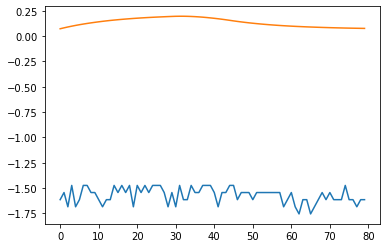

In [77]:
# plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[2]].pressure.values)
plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[1]].pressure.values)
plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[1]].u_in.values)
# plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[3]].pressure.values)
# plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[4]].pressure.values)
# plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[5]].pressure.values)


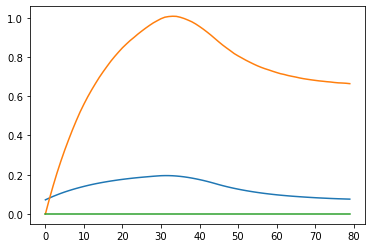

In [75]:
# plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[2]].u_in.values)
plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[1]].u_in.values)
plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[0]].u_in.values)
# plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[3]].u_in.values)
plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[4]].u_in.values)
# plt.plot(train_df.loc[train_df.breath_id==(train_df.loc[train_df['pressure']<=0,'breath_id']).unique()[5]].u_in.values)


In [292]:
# mins.loc[mins.breath_id.isin((train_df.loc[train_df['pressure']>0,'breath_id']).unique())].corr()['pressure']
train_df_2= train_df.copy()



In [293]:
# ((train_df_1.groupby('breath_id').size())==80).all()

In [294]:
# train_df_1[]
train_df_2['id'] = train_df_2['id']%80 

In [295]:
# train_df[train_df['id']== 81] 
train_df_2.loc[(train_df_2['id']==0),'id'] = 80

In [296]:
train_df_2

,id,breath_id,time_step,u_in,u_out,pressure,area,u_in_cumsum,u_in_diff,time_step_diff,air_press_lung,air_press_lung_cumsum,sgn_u_in_diff,sgn_u_in_diff_cumsum,u_in_lag2,u_in_lag4,R_20,R_5,R_50,C_10,C_20,C_50,ewm_u_in_mean,ewm_u_in_std,ewm_u_in_corr,rolling_10_mean,rolling_10_max,rolling_10_std,expand_mean,expand_max,expand_std,time_step_log
0,1,1,0.000000,0.083334,0,5.837492,0.000000,0.083334,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1,0,0,0,0,1,0.083334,NaN,NaN,0.083334,0.083334,NaN,NaN,NaN,NaN,0.000000
1,2,1,0.033652,18.383041,0,5.907794,0.618632,18.466375,18.299707,0.033652,0.615827,0.615827,1.0,1.0,0.000000,0.000000,1,0,0,0,0,1,9.550171,12.939847,1.0,9.233188,18.383041,12.939847,9.233188,18.383041,12.939847,0.033098
2,3,1,0.067514,22.509278,0,7.876254,2.138333,40.975653,4.126236,0.033862,0.139723,0.755550,1.0,2.0,0.083334,0.000000,1,0,0,0,0,1,14.172507,11.777739,1.0,13.658551,22.509278,11.936136,13.658551,22.509278,11.936136,0.065333
3,4,1,0.101542,22.808822,0,11.742872,4.454391,63.784476,0.299544,0.034028,0.010193,0.765743,1.0,3.0,18.383041,0.000000,1,0,0,0,0,1,16.560977,10.448647,1.0,15.946119,22.808822,10.766279,15.946119,22.808822,10.766279,0.096711
4,5,1,0.135756,25.355850,0,12.234987,7.896588,89.140326,2.547028,0.034213,0.087142,0.852886,1.0,4.0,22.509278,0.083334,1,0,0,0,0,1,18.571834,9.801731,1.0,17.828065,25.355850,10.229525,17.828065,25.355850,10.229525,0.127298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,76,125749,2.504603,1.489714,1,3.869032,270.089574,387.109297,0.069002,0.033412,0.002305,-0.154798,1.0,-11.0,1.353205,1.362261,0,0,1,1,0,0,1.736896,2.367440,1.0,1.346222,1.489714,0.085995,5.093543,25.504196,5.656816,1.254077
6035996,77,125749,2.537961,1.488497,1,3.869032,273.867320,388.597794,-0.001217,0.033358,-0.000041,-0.154839,-1.0,-12.0,1.420711,1.357586,0,0,1,1,0,0,1.720181,2.287248,1.0,1.376636,1.489714,0.075534,5.046725,25.504196,5.634475,1.263551
6035997,78,125749,2.571408,1.558978,1,3.798729,277.876088,390.156772,0.070481,0.033447,0.002357,-0.152481,1.0,-11.0,1.489714,1.353205,0,0,1,1,0,0,1.709337,2.209336,1.0,1.400848,1.558978,0.091385,5.002010,25.504196,5.611681,1.272960
6035998,79,125749,2.604744,1.272663,1,4.079938,281.191050,391.429435,-0.286315,0.033337,-0.009545,-0.162026,-1.0,-12.0,1.488497,1.420711,0,0,1,1,0,0,1.679971,2.136635,1.0,1.404347,1.558978,0.084882,4.954803,25.504196,5.591358,1.282251


In [297]:
# train_df_1[['id','breath_id','pressure']]
# train_p_2 = train_df_2.pivot(index='breath_id', columns='id', values='u_in')
# train_df_1[['id','breath_id','pressure']]
train_p_3 = train_df_2.pivot(index='id', columns='breath_id', values='pressure')


In [ ]:
train_p_3

In [300]:
# gc.collect()

In [254]:
# train_df_1.loc[train_df_1.id.isin(abs(train_p.corr()[1]).sort_values(ascending = False).index.tolist()) & train_df_1.breath_id == 1,'pressure']
# sns.distplot(train_p[3])
# sns.distplot(train_p_2[30])
# train_p[1]
# sns.distplot(train_p[2])
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, random_state=123, n_init=10)
preds = gm.fit_predict(train_p)

In [281]:
# gm.n_features_in_
# gm.precisions_.shape
# gm.means_
susm = train_df.groupby('breath_id').agg('max')

In [303]:
# susm[(susm['pressure']<0)]
from sklearn.decomposition import PCA
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=0.99)
pca.fit(train_p_3)

PCA(n_components=0.99)

In [ ]:
pca.n_components_
# pca.n_samples_
train_p_3


In [257]:
gm_2 = GaussianMixture(n_components=5, random_state=123, n_init=10)
preds_2 = gm_2.fit_predict(train_p_2)

In [265]:
gm_2.converged_

True

In [87]:
tr1 = train_df.loc[train_df.breath_id.isin(maxes.loc[maxes.sgn_u_in_diff_cumsum == maxes['sgn_u_in_diff_cumsum'].unique()[32]].index.tolist())]
plt.plot(tr1.loc[tr1.breath_id == tr1.breath_id.unique()[0],'pressure'].values)
plt.plot(tr1.loc[tr1.breath_id == tr1.breath_id.unique()[1],'pressure'].values)
plt.plot(tr1.loc[tr1.breath_id == tr1.breath_id.unique()[2],'pressure'].values)


IndexError: index 32 is out of bounds for axis 0 with size 32

In [90]:
# sns.distplot(maxes.time_step.values)
from sklearn.cluster import KMeans
def elbow_explore(df,fea):
    
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df[fea].values.reshape(-1, 1))
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [91]:
# maxes.columns.tolist()
# train_df.loc[train_df.u_out == 0].groupby('breath_id')['u_in_diff']

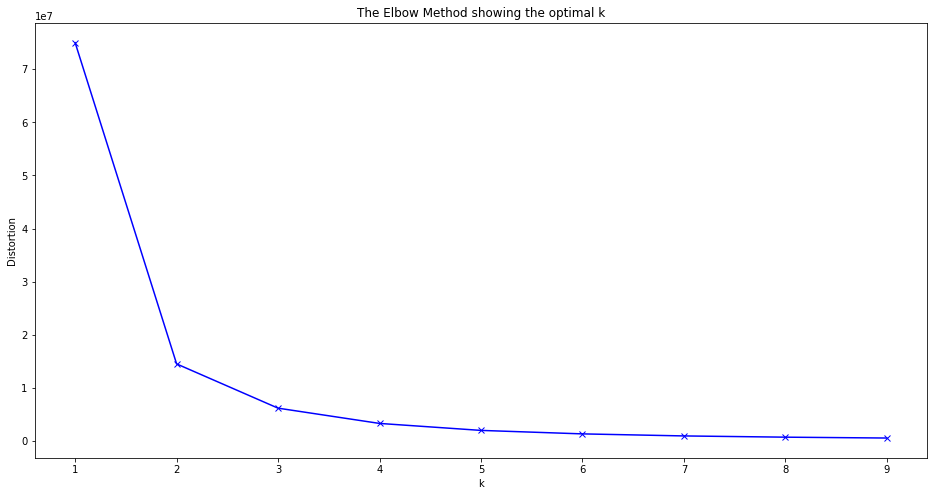

In [123]:
elbow_explore(maxes,'u_in')

In [121]:
(maxes.u_in <= 0).sum()

95

<AxesSubplot:xlabel='u_in', ylabel='Density'>

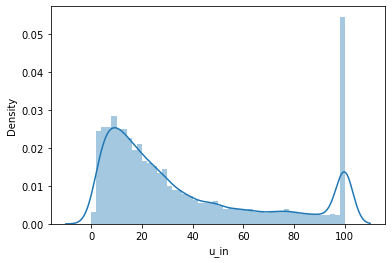

In [122]:
sns.distplot(maxes.u_in)